<a href="https://colab.research.google.com/github/EmilSkaaning/MILC_IT_UCPH/blob/colab_b/hackathon/SHAPvalues/Yogurt_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon in SHAPvalues
Welcome to the first MILC_IT Hackathon!
Pleas make sure to copy this colab to your own drive if you want to change in it.  

File -> Save a copy in drive

In [1]:
!rm -rf MILC_IT_UCPH/ 

We start by cloning the MILC_IT's GitHub to access data, the requirements file and importing the necesarry libraries.

In [19]:
!git clone https://github.com/EmilSkaaning/MILC_IT_UCPH.git
!pip install -r MILC_IT_UCPH/hackathon/SHAPvalues/requirements.txt

from sklearn.datasets import load_wine
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

fatal: destination path 'MILC_IT_UCPH' already exists and is not an empty directory.


# The data
## Quick info
It's samples of yogurt where the concentration of riboflavin has been measured with excitation and emission spectroscopy. There's is also further information about each sample in the file "info_conditions.csv" and "conditions.csv". The file "conditions.csv" has the following four extra variables about each sample:

Batch no. (0/1)
Light (0=Light, 1=darkness)
Packaging (0=polylactate, 1=polystyrene)
Storage time in days
For more info, please refer to the following paper. This paper should also be cited if you intend to use this dataset for anything serious :-): Christensen, J., Miquel Becker, E., and Frederiksen, C.S. Fluorescence Spectroscopy and PARAFAC in analysis of yoghurt Chemometrics and Intelligent Laboratory 75(2005)201-208

Lets start by having a look at the data.

In [25]:
riboflavin = np.genfromtxt("MILC_IT_UCPH/hackathon/data/yogurt/riboflavin.csv", delimiter=",")  # concentrations of riboflavin
em = np.genfromtxt("MILC_IT_UCPH/hackathon/data/yogurt/Em.csv", delimiter=",")  # emission axis
ex = np.genfromtxt("MILC_IT_UCPH/hackathon/data/yogurt/Ex.csv", delimiter=",")  # excitation axis
X = np.genfromtxt("MILC_IT_UCPH/hackathon/data/yogurt/X.csv", delimiter=",")  # measurements
conditions = np.genfromtxt("MILC_IT_UCPH/hackathon/data/yogurt/conditions.csv", delimiter=",")

In [6]:
print(f"Values on the emission axis: {em}")
print(f"Values on the excitation axis: {ex}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Values on the emission axis: [310. 330. 350. 370. 390. 410. 430. 450. 470. 490. 510. 530. 550. 570.
 590.]
Values on the excitation axis: [270. 290. 310. 330. 350. 370. 390. 410. 430. 450. 470. 490. 510. 530.
 550.]
Number of samples: 125
Number of features: 225


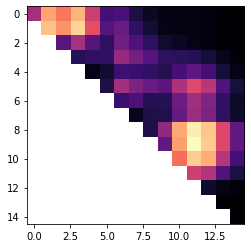

In [12]:
X_2dhists = np.array([x.reshape((15, 15)) for x in X])
plt.imshow(X_2dhists[0], cmap='magma')

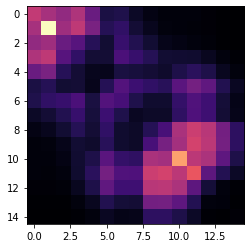

In [14]:
new_X = []
for sample in X_2dhists:
    tmp = np.nan_to_num(sample.copy())
    tmp_diag = np.diag(tmp)

    tmp += tmp.T
    indices = np.arange(len(tmp))
    tmp[indices, indices] = tmp_diag

    new_X.append(tmp)
new_X = np.array(new_X)
plt.imshow(new_X[0], cmap='magma')
plt.show()

# PCA

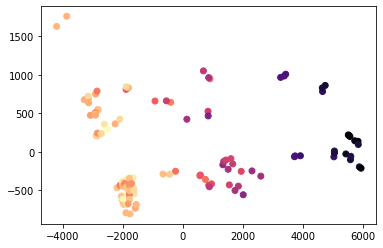

In [16]:
pca = PCA(n_components=2)
new_X = np.array([x.ravel() for x in new_X])  # ravel/flatten to make it nice for PCA
trans = pca.fit_transform(new_X)

plt.scatter(trans[:, 0], trans[:, 1], c=riboflavin, cmap='magma')
plt.show()

In [22]:
no_nan_riboflavin = riboflavin[~np.isnan(riboflavin)]
X = new_X[~np.isnan(riboflavin)]
x_train, x_test, y_train, y_test = train_test_split(X, no_nan_riboflavin, test_size=0.3, random_state=42)

model = LinearRegression()
rfe = RFE(estimator=LinearRegression(), n_features_to_select=3, step=1)

cv_results = cross_validate(model, X, no_nan_riboflavin, scoring='neg_mean_squared_error', cv=10)
print(f"CV RMSE w/o FS: {cv_results['test_score'].mean()*-1:.4}")

cv_results = cross_validate(rfe, X, no_nan_riboflavin, scoring='neg_mean_squared_error', cv=10)
print(f"CV RMSE w. FS: {cv_results['test_score'].mean()*-1:.4}")

CV RMSE w/o FS: 0.1533
CV RMSE w. FS: 0.06041


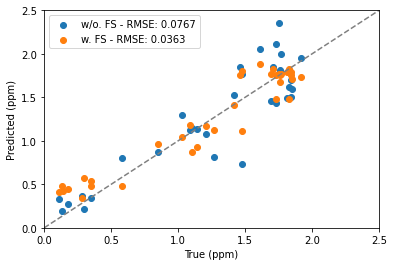

In [23]:
fig, ax = plt.subplots()

# without feature selection
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
ax.scatter(y_test, y_pred, label=f"w/o. FS - RMSE: {metrics.mean_squared_error(y_test, y_pred):.3}")

# with feature selection
rfe.fit(x_train, y_train)
y_pred = rfe.predict(x_test)
ax.scatter(y_test, y_pred, label=f"w. FS - RMSE: {metrics.mean_squared_error(y_test, y_pred):.3}")
ax.plot([0, 2.5], [0, 2.5], linestyle="--", c="grey")

ax.set_xlim(0, 2.5)
ax.set_ylim(0, 2.5)
ax.set_xlabel("True (ppm)")
ax.set_ylabel("Predicted (ppm)")
ax.legend()

plt.show()

# Shap values

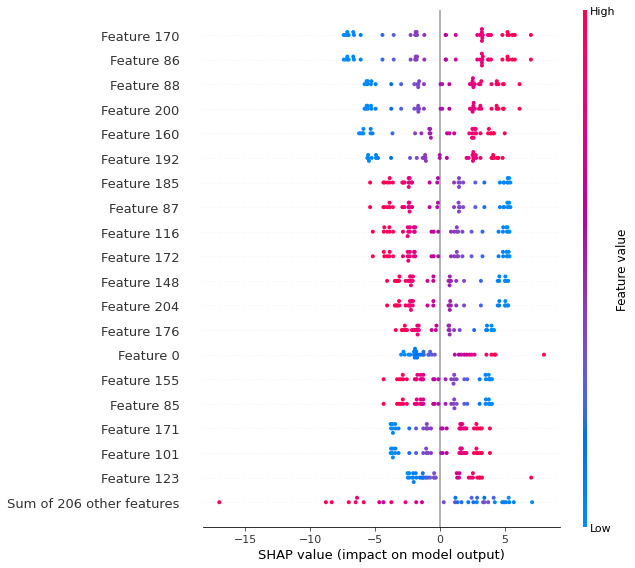

'shap_values_ebm = explainer_ebm(X)\n\n# calculate shap values. This is what we will plot.\n# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.\nshap_values = explainer.shap_values(x_test)\n\n# Make plot. Index of [1] is explained in text below.\nshap.summary_plot(shap_values[1], x_test)'

In [33]:
# Create object that can calculate shap values
explainer = shap.Explainer(model.predict, x_test)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer(x_test)

# Make plot
shap.plots.beeswarm(shap_values, max_display=20)

# Make information and plots for linear regression
# https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#linear_regression

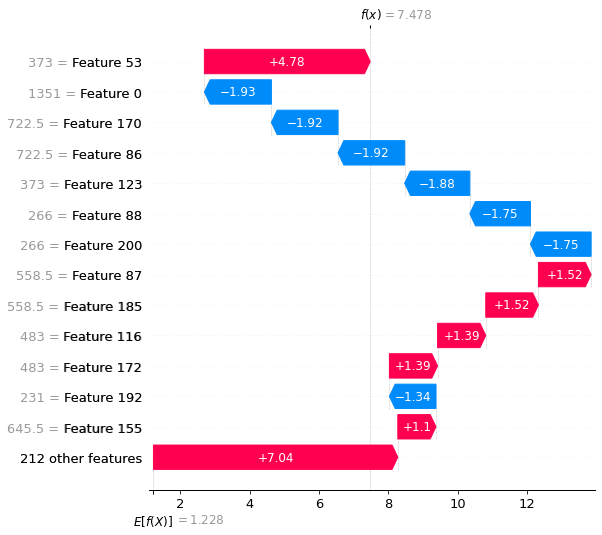

In [46]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
sample_idx = 1
shap.plots.waterfall(shap_values[sample_idx], max_display=14)

# Now it's your turn!
The following code appends the data from conditions.csv and naïvely removes the nans, but does nothing more. See if the info from conditions.csv provides a better estimate. Maybe another model does a better job than the linear regression? What about interpretability? etc. etc.

In [27]:
X = np.genfromtxt("MILC_IT_UCPH/hackathon/data/yogurt/X.csv", delimiter=",")  # measurements
X_w_conditions = np.hstack((X, conditions))
print(f"Old amount of features ({X.shape[1]}) + features from `conditions.csv` ({conditions.shape[1]}) = new number of features ({X_w_conditions.shape[1]})")

Old amount of features (225) + features from `conditions.csv` (4) = new number of features (229)
